# Linear regression

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd
import pylab as py

### Data production

Data generation according to a linear relationship: 

$$
y = \theta_0 + \theta_1 \cdot x
$$

Parameters for the simulation: $\theta_0 = 1$ i $\theta_1 = 3$.

$$
\vec{\theta} = (\theta_{0}, \theta_{1})
$$

In [30]:
theta0 = 1
theta1 = 3
theta = np.array([theta0, theta1])

Data generation (**nPoints**) according the model and adding column with Gaussian noise data: $$ y_{noise} = y + Rand(N(0,1)) $$

In [31]:
nPoints = 100
x = np.linspace(0, 10, nPoints)
x = np.reshape(x, (-1,1))

df = pd.DataFrame(data=x, columns = ["x"])
df["y"] = theta[0] + df["x"]*theta[1]
df["y_noise"] = df.y + np.random.randn(100)
df

,x,y,y_noise
0,0.00000,1.000000,1.363748
1,0.10101,1.303030,1.323108
2,0.20202,1.606061,0.733280
3,0.30303,1.909091,1.824942
4,0.40404,2.212121,3.277859
...,...,...,...
95,9.59596,29.787879,31.340461
96,9.69697,30.090909,30.622207
97,9.79798,30.393939,30.962635
98,9.89899,30.696970,29.133592


### Data visualisation

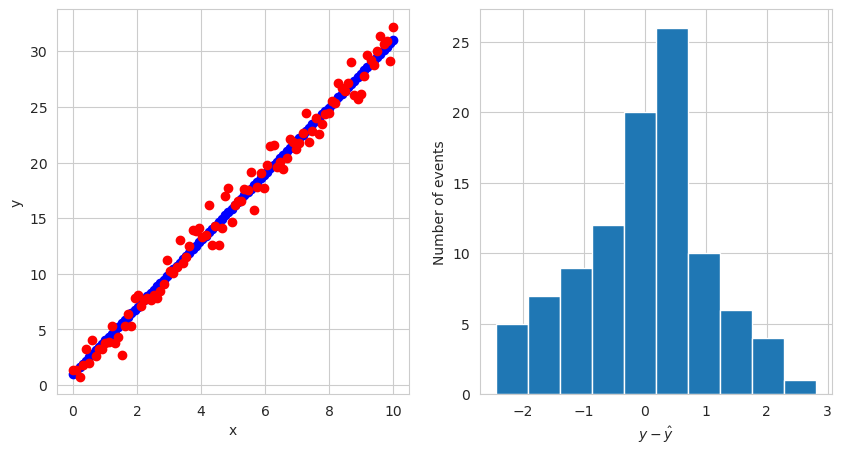

In [32]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1,2, figsize=(10,5))

axes[0].plot(df.x, df.y, "bo", df.x, df.y_noise, "ro")
axes[1].hist(df.y - df.y_noise)

axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[1].set_xlabel(r'$y - \hat{y}$')
axes[1].set_ylabel("Number of events");

### Normal equations algorithm
#### Calculation the parameters minimizing the loss function
$\qquad$$ \theta = (X^T X )^{-1} X^T \mathbf {y}$

In [33]:
def normal_equations(x,y):  
    x_expanded = np.column_stack((np.ones(x.shape[0]), x))
    theta = np.dot(np.dot(np.linalg.inv(np.dot(x_expanded.T, x_expanded)), x_expanded.T), y)
    return theta

theta_est = normal_equations(df["x"], df["y"])
print("Values estimated using normal equations for nominal data:", theta_est.T)

Values estimated using normal equations for nominal data: [1. 3.]


In [34]:
theta_est = normal_equations(df["x"], df["y_noise"])
print("Values estimated using normal equations for noisy data:", theta_est.T)

df_subsample = df.sample(frac=0.05)
theta_est = normal_equations(df_subsample["x"], df_subsample["y_noise"])
print(f"Values estimated using normal equations for noisy data: {theta_est.T} for 5% cases.")

Values estimated using normal equations for noisy data: [0.93053075 3.01544652]
Values estimated using normal equations for noisy data: [1.8584411  2.87688791] for 5% cases.


### Gradient descent
#### based on least squares algorithm 

In [35]:
%%time
def iterative_batch_gradient(x, y, init_theta, alpha, nIter): 
    theta = init_theta
    theta_est = np.copy(theta)
    theta_est = np.reshape(theta_est, (-1,len(theta)))
    batchSize = len(x)
    for iteration in range(nIter):  
        x_batch = np.column_stack((np.ones(batchSize), x))
        y_batch = y   
        delta = 2.0*alpha*(np.sum(theta*x_batch, axis=1) - y_batch)
        delta = np.array(delta)
        delta = np.reshape(delta, (-1,1))     
        delta = delta*x_batch     
        delta = np.mean(delta, axis=0)
        delta = np.reshape(delta, (1,-1)) 
        theta = theta - delta
        theta_est = np.append(theta_est, theta, axis=0)
    return theta_est

theta_est = iterative_batch_gradient(df["x"], df["y"], init_theta=theta, alpha=0.01, nIter=1)    
print("Values estimated using the nominal initial value of theta parameters:",theta_est[-1])

theta_est = iterative_batch_gradient(df["x"], df["y"], init_theta=theta+1, alpha=0.01, nIter=500)    
print("Values estimated using non-nominal initial value of theta parameters:",theta_est[-1])

Values estimated using the nominal initial value of theta parameters: [1. 3.]
Values estimated using non-nominal initial value of theta parameters: [1.06901228 2.9896233 ]
CPU times: user 107 ms, sys: 9.02 ms, total: 116 ms
Wall time: 103 ms


### Stochastic gradient descent
#### based on least squares algorithm 

In [36]:
%%time
def iterative_stochastic_gradient(x, y, init_theta, alpha, nIter):
    theta = init_theta
    theta = np.reshape(theta,(1,2))
    theta_est = np.copy(theta)
    theta_est = np.reshape(theta_est, (-1,2))
    indices = np.random.randint(low=0, high=len(x)-1, size=(nIter))
    x_expanded = np.column_stack((np.ones(x.shape[0]), x))
    for iteration in range(nIter):
        x_sample = x[indices[iteration]]
        x_sample = np.column_stack((np.ones(1), x_sample))
        y_sample = y[indices[iteration]]
        theta = theta - 2.0*alpha*(np.dot(theta, x_sample.T) - y_sample)*x_sample
        theta_est = np.append(theta_est, theta, axis=0)
    return theta_est

theta_est = iterative_stochastic_gradient(df["x"], df["y"], theta, 0.01, 1)    
print("Values estimated using the nominal initial value of theta parameters:",theta_est[-1])

theta_est = iterative_stochastic_gradient(df["x"], df["y"], theta+1, 0.01, 10)    
print("Values estimated using non-nominal initial value of theta parameters:",theta_est[-1])

Values estimated using the nominal initial value of theta parameters: [1. 3.]
Values estimated using non-nominal initial value of theta parameters: [1.80253979 2.84849215]
CPU times: user 7.26 ms, sys: 95 µs, total: 7.36 ms
Wall time: 4.81 ms


In [37]:
theta_alpha_01 = iterative_stochastic_gradient(df["x"], df["y_noise"], theta+1, alpha = 0.1, nIter = 10) 
theta_alpha_005 = iterative_stochastic_gradient(df["x"], df["y_noise"], theta+1, alpha = 0.05, nIter = 10) 
theta_alpha_001 = iterative_stochastic_gradient(df["x"], df["y_noise"], theta+1, alpha = 0.01, nIter = 10)
theta_alpha = iterative_stochastic_gradient(df["x"], df["y_noise"], theta+1, alpha = 0.01, nIter = 100)

print("Final parameter value for alpha=0.1, nIter = 10:",theta_alpha_01[-1])
print("Final parameter value for alpha=0.05, nIter = 10:",theta_alpha_005[-1])
print("Final parameter value for alpha=0.001, nIter = 10:",theta_alpha_001[-1])
print("Final parameter value for alpha=0.001, nIter = 100:",theta_alpha[-1])
print("Original parameter value:",theta)

Final parameter value for alpha=0.1, nIter = 10: [-2019.52031214 -3024.96361126]
Final parameter value for alpha=0.05, nIter = 10: [2.24164268 4.42995881]
Final parameter value for alpha=0.001, nIter = 10: [1.72580987 2.82580451]
Final parameter value for alpha=0.001, nIter = 100: [1.47521603 2.86508511]
Original parameter value: [1 3]


### Modeling the number of cyclists using linear regression using gradient decent

In [38]:
df = pd.read_csv("data.csv", sep=",",parse_dates=[0])
df = df.rename(columns={' ' : "Data"})
df = df.fillna(0)
df

,Data,Armii Krajowej,Bora-Komorowskiego,Bulwary,Dworzec,Grzegórzecka,Kamieńskiego,Klimeckiego,Kopernika,Kotlarska,...,Smoleńsk,Tyniecka,Wadowicka,Wielicka,Średnia temp.,Min. temp.,Maks. temp.,Odczuwalna temp.,Opady (mm),Wiatr
0,2016-11-18,0.0,0.0,421,0,0.0,0.0,0.0,0.0,560,...,0.0,0.0,212,329,7.0,3.0,11.0,4.0,0.0,8.0
1,2016-11-19,0.0,0.0,328,0,0.0,0.0,0.0,0.0,232,...,0.0,0.0,206,151,9.0,5.0,13.0,7.0,0.0,11.0
2,2016-11-20,0.0,0.0,539,0,0.0,0.0,0.0,0.0,285,...,0.0,0.0,212,182,8.0,4.0,11.0,6.0,0.0,9.0
3,2016-11-21,0.0,0.0,1002,0,0.0,0.0,0.0,0.0,953,...,0.0,0.0,382,479,10.0,6.0,14.0,7.0,0.0,11.0
4,2016-11-22,0.0,0.0,1132,,0.0,0.0,0.0,0.0,1039,...,0.0,0.0,386,502,10.0,6.0,13.0,7.0,0.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2182,2022-11-09,825.0,906.0,1384,1929,1967.0,874.0,1247.0,2350.0,2283,...,1010.0,993.0,1377,1303,0.0,0.0,0.0,0.0,0.0,0.0
2183,2022-11-10,514.0,658.0,783,1440,1505.0,673.0,921.0,1741.0,1743,...,846.0,437.0,972,909,0.0,0.0,0.0,0.0,0.0,0.0
2184,2022-11-11,536.0,397.0,1329,764,1035.0,561.0,720.0,1174.0,1120,...,470.0,1407.0,646,610,0.0,0.0,0.0,0.0,0.0,0.0
2185,2022-11-12,523.0,496.0,1288,827,1045.0,635.0,643.0,1049.0,986,...,518.0,1449.0,627,646,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.3)

In [44]:
street_names =  ['Bora-Komorowskiego',
       'Klimeckiego', 'Kopernika', 'Kotlarska',
       'Monte Cassino', 'Nowohucka', 'Smoleńsk',
       'Tyniecka', 'Wadowicka']

alpha = 1E-1
nIter = 1000

x = df_train[street_names]
y = df_train["Mogilska"]
init_theta = np.ones(x.shape[1]+1)

In [45]:
from termcolor import colored

def trainLinearRegression(x, y, init_theta, alpha, nIter):
    x = x/x.max()
    theta = iterative_batch_gradient(x, y, init_theta, alpha, nIter)
    theta = theta[-1]
    return theta

def plotLinearRegression(x,y, theta):
    x = x/x.max()
    x = np.column_stack((np.ones(len(x)), x))
    y_pred = np.sum(theta*x, axis=1)
    pull = (y-y_pred)/y
        
    plt.hist(pull, bins=np.arange(-1,1,0.1), alpha = 0.5);
    print(colored("Pull. Mean:","blue"),"{:.2f}".format(np.mean(pull)), end=" ")
    print(colored("std.:","blue"),"{:.2f}".format(np.std(pull)))

Result on train dataset: Pull. Mean: -0.09 std.: 0.31
Result on test dataset: Pull. Mean: 0.03 std.: 0.29


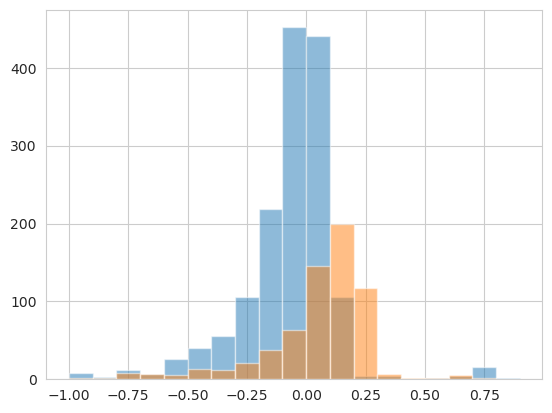

In [46]:
theta = trainLinearRegression(x, y, init_theta, alpha, nIter)
print(colored("Result on train dataset:","green"), end=" ")
plotLinearRegression(x,y, theta)

x = df_test[street_names]
y = df_test["Mogilska"]
print(colored("Result on test dataset:","green"), end=" ")
plotLinearRegression(x,y, theta)